In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import RegressorMixin
from sklearn.tree import DecisionTreeRegressor

In [4]:
csv_file_path_train = 'energy_train.csv'
csv_file_path_val   = 'energy_val.csv'
csv_file_path_test  = 'energy_test.csv'

# Read the CSV file into a Pandas DataFrame
df_train = pd.read_csv(csv_file_path_train)
df_val   = pd.read_csv(csv_file_path_val  )
df_train = pd.concat([df_train, df_val], axis=0)
df_train = df_train.reset_index(drop=True)
df_test  = pd.read_csv(csv_file_path_test )

In [5]:
df_train.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,1/11/16 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3
1,1/11/16 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2
2,1/11/16 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1
3,1/11/16 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0
4,1/11/16 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9


In [6]:
def feature_extraction(df, normalization='z-score'):
    import warnings
    warnings.filterwarnings('ignore')
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract the day of the week and create a new column
    df['DayOfWeek'] = df['date'].dt.day_name()
    
    # Create a new column for 2-hour intervals
    df['TimeInterval'] = df['date'].dt.strftime('%H:%M:%S').str[:2].astype(int) // 2 * 2
    
    # Encode 'TimeInterval' using one-hot encoding
    df['TimeInterval'] = df['TimeInterval'].astype(str)
    
    # import OneHotEncoder
    from sklearn.preprocessing import OneHotEncoder
    
    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Fit the encoder on the categorical column and transform it
    encoded_data = encoder.fit_transform(df[['DayOfWeek', 'TimeInterval']])
    
    # Create a new DataFrame with one-hot encoded columns
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['DayOfWeek', 'TimeInterval']))
    y = np.reshape(df['Appliances'].to_numpy(), (-1, 1))
    
    # Drop the original 'Category' column
    df.drop(columns=['DayOfWeek', 'TimeInterval', 'date', 'Appliances'], inplace=True)
    
    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    X = pd.concat([df, encoded_df], axis=1).to_numpy()
    
    return X, y

In [7]:
# preprocess data
trainx, trainy = feature_extraction(df_train)
testx, testy = feature_extraction(df_test)

# normaliztion
scaler = StandardScaler()
trainx = scaler.fit_transform(trainx)
# Transform the testing data based on the fitted scaler
testx = scaler.transform(testx)

# flatten y to be 1D numpy array
trainy = trainy.flatten()
testy = testy.flatten()

In [11]:
def tune_sgtb(x, y, lst_nIter, lst_nu, lst_q, md):
    # create SGTB model
    model = SGTB(md=md)
    
    # Define the hyperparameter grid to search
    param_grid = {
        'nIter': lst_nIter,  
        'q': lst_q, 
        'nu': lst_nu, 
    }
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2)
    
    # Perform grid search with cross-validation
    grid_search.fit(x, y)
    
    # Get the best hyperparameters
    best_nIter = grid_search.best_params_['nIter']
    best_q = grid_search.best_params_['q']
    best_nu = grid_search.best_params_['nu']
    best_score = grid_search.best_score_
    
    # Access the cross-validation results
    cv_results = grid_search.cv_results_
    
    return {'best-nIter': best_nIter, 'best-nu': best_nu, 'best-q': best_q, 
            'best-RMSE': best_score, 'grid_search': grid_search, 'cv-results':cv_results}


def compute_residual(y_true, y_pred):
    return y_true - y_pred


class SGTB(RegressorMixin):
    def __init__(self, nIter=1, q=1, nu=0.1, md=3):
        self.nIter = nIter # number of boosting iterations
        self.q = q # subsampling rate
        self.nu = nu # shrinkage parameter
        self.md = md # max depth of the tree that is trained at each iteration
        # key is the iteration and the value is the RMSE of the training data. Note that for the 0th iteration,
        # it should return the RMSE for a model that predicts the mean of y and the 1st iteration would return
        # the RMSE for a single tree fit to the initial set of residuals multiplied by the shrinkage rate.
        self.train_dict = {} 

    def get_params(self, deep=True):
        return {"nIter": self.nIter,
                "q": self.q,
                "nu": self.nu,
                "md": self.md}

    # set the parameters
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    # train data using gradient boosting
    def fit(self, x, y):
        # to store h_m at m-th iteration
        self.model = []
        # target mean
        f_0 = np.mean(y)
        # add f_0 to models
        self.model.append(f_0)
        # calculate RMSE at 0th iteration
        y_pred = self.model[0] * np.ones(x.shape[0])
        self.train_dict[0] = mean_squared_error(y, y_pred, squared=False)
        
        for m in range(1, self.nIter + 1):
            # size of subsampled dataset
            n = int(x.shape[0] * self.q)
            # indices to be selected from dataset
            idx = np.random.choice(x.shape[0], n, replace=False)
            # retrive subsampled data
            x_sub = x[idx, :]
            y_sub = y[idx]
            # make prediction on x_sub to calculate residuals
            y_sub_pred = self.model[0] * np.ones(n)
            for i in range(1, m):
                # calculate similar to line 6 of Alg1
                y_sub_pred += self.nu * self.model[i].predict(x_sub)
            # calculate residuals
            r_m = compute_residual(y_sub, y_sub_pred)
            # instantiate decision tree regressor model
            h_m = DecisionTreeRegressor(max_depth=self.md)
            # train h_m
            h_m.fit(x_sub, r_m)
            # add h_m to the list of models
            self.model.append(h_m)
            # update self.train_dict
            y_sub_pred += self.nu * self.model[m].predict(x_sub)
            self.train_dict[m] = mean_squared_error(y_sub, y_sub_pred, squared=False)
        return self

    def predict(self, x):
        # number of samples
        n_sample = x.shape[0]
        # build the output
        y = self.model[0] * np.ones(n_sample)
        
        for i in range(1, self.nIter):
            # retrieve h_m form list of models
            h_m = self.model[i]
            # predict on data
            y += self.nu * h_m.predict(x)
        
        return y



In [10]:
lst_nIter = list(range(1, 21))
lst_nu = list(np.arange(0.1, 1.01, 0.05))
lst_q = [1]
md = 3

result = tune_sgtb(trainx, trainy, lst_nIter, lst_nu, lst_q, md)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits
[CV] END ...............................nIter=1, nu=0.1, q=1; total time=   0.0s
[CV] END ...............................nIter=1, nu=0.1, q=1; total time=   0.0s
[CV] END ...............................nIter=1, nu=0.1, q=1; total time=   0.0s
[CV] END ...............................nIter=1, nu=0.1, q=1; total time=   0.0s
[CV] END ...............................nIter=1, nu=0.1, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=1, nu=0.2000000

[CV] END ...............nIter=2, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.15000000000000002, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.20000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=2, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIte

[CV] END ...............nIter=3, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.25000000000000006, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.30000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.30000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.30000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.30000000000000004, q=1; total time=   0.0s
[CV] END ...............nIter=3, nu=0.30000000000000004, q=1; total time=   0.0s
[CV] END ................nIter=3, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=3, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=3, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=3, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIt

[CV] END ................nIter=4, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=4, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=4, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ................nIter=4, nu=0.3500000000000001, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.40000000000000013, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.40000000000000013, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.40000000000000013, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.40000000000000013, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.40000000000000013, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.45000000000000007, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.45000000000000007, q=1; total time=   0.0s
[CV] END ...............nIter=4, nu=0.45000000000000007, q=1; total time=   0.0s
[CV] END ...............nIte

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


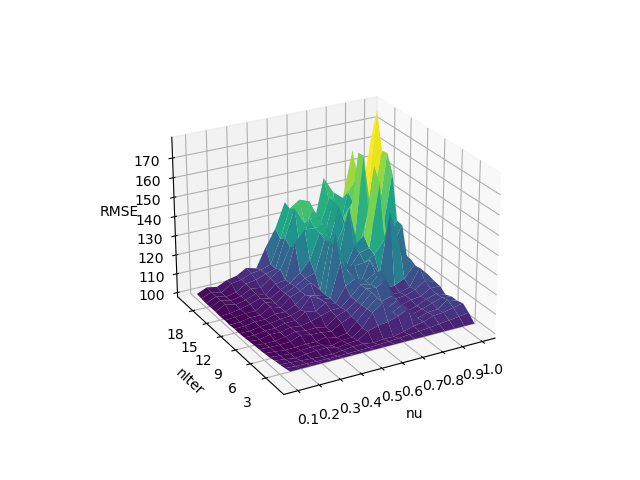

In [26]:
%matplotlib notebook

# Create a 3D plot for scores and parameters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Set integer ticks on the x, y, and z axes
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
X, Y = np.meshgrid(lst_nu, lst_nIter)
mean_test_scores = np.array(-result['cv-results']['mean_test_score']).reshape(len(lst_nIter), -1)

ax.plot_surface(X, Y, mean_test_scores, cmap='viridis')
ax.set_ylabel('nIter')
ax.set_xlabel('nu')
ax.set_zlabel('RMSE')

plt.show()

In [25]:
# train decision tree using best parameters
nIter = result['best-nIter']
nu = result['best-nu']
q = 1
md = 3

# Create a Decision Tree classifier
model = SGTB(nIter, q, nu, md)

# train model
model.fit(trainx, trainy)

# make prediction on test data
testy_pred = model.predict(testx)
trainy_pred = model.predict(trainx)

print('nIter: ', nIter)
print('nu: ', nu)
print('q: ', q)
print('max depth: ', md)
print('------------------')
print('RMSE train', mean_squared_error(trainy, trainy_pred, squared=False))
print('R2 train', r2_score(trainy, trainy_pred))
print('RMSE test', mean_squared_error(testy, testy_pred, squared=False))
print('R2 test', r2_score(testy, testy_pred))

nIter:  5
nu:  0.40000000000000013
q:  1
max depth:  3
------------------
RMSE train 94.05626084587915
R2 train 0.18901058022111805
RMSE test 93.52278992845942
R2 test -0.05916078472084951


In [29]:
lst_nIter = list(range(1, 21))
lst_nu = list(np.arange(0.05, 0.41, 0.05))
lst_q = [0.6, 0.7, 0.8, 0.9, 1]
md = 3

result = tune_sgtb(trainx, trainy, lst_nIter, lst_nu, lst_q, md)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV] END ............................nIter=1, nu=0.05, q=0.6; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.6; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.6; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.6; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.6; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=1,

[CV] END ............................nIter=1, nu=0.25, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.7; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.9; total time=   0.0s
[CV] END ............................nIter=1, nu=0.25, q=0.9; total time=   0.0s
[CV] END ...................

[CV] END ............................nIter=2, nu=0.05, q=0.7; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.05, q=0.9; total time=   0.0s
[CV] END ..............................nIter=2, nu=0.05, q=1; total time=   0.0s
[CV] END ...................

[CV] END ............................nIter=2, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.8; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.9; total time=   0.0s
[CV] END ............................nIter=2, nu=0.25, q=0.9; total time=   0.0s
[CV] END ..............................nIter=2, nu=0.25, q=1; total time=   0.1s
[CV] END ..............................nIter=2, nu=0.25, q=1; total time=   0.1s
[CV] END ..............................nIter=2, nu=0.25, q=1; total time=   0.1s
[CV] END ...................

[CV] END ............................nIter=3, nu=0.05, q=0.8; total time=   0.1s
[CV] END ............................nIter=3, nu=0.05, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.05, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.05, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.05, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.05, q=0.9; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.05, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.05, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.05, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.05, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.05, q=1; total time=   0.1s
[CV] END .............................nIter=3, nu=0.1, q=0.6; total time=   0.0s
[CV] END ...................

[CV] END ............................nIter=3, nu=0.25, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.25, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.25, q=0.9; total time=   0.1s
[CV] END ............................nIter=3, nu=0.25, q=0.9; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.25, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.25, q=1; total time=   0.1s
[CV] END ..............................nIter=3, nu=0.25, q=1; total time=   0.2s
[CV] END ..............................nIter=3, nu=0.25, q=1; total time=   0.2s
[CV] END ..............................nIter=3, nu=0.25, q=1; total time=   0.2s
[CV] END .............................nIter=3, nu=0.3, q=0.6; total time=   0.0s
[CV] END .............................nIter=3, nu=0.3, q=0.6; total time=   0.0s
[CV] END .............................nIter=3, nu=0.3, q=0.6; total time=   0.0s
[CV] END ...................

[CV] END ............................nIter=4, nu=0.05, q=0.9; total time=   0.1s
[CV] END ............................nIter=4, nu=0.05, q=0.9; total time=   0.1s
[CV] END ..............................nIter=4, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.05, q=1; total time=   0.2s
[CV] END .............................nIter=4, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.1, q=0.6; total time=   0.1s
[CV] END ...................

[CV] END ..............................nIter=4, nu=0.25, q=1; total time=   0.1s
[CV] END ..............................nIter=4, nu=0.25, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.25, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.25, q=1; total time=   0.2s
[CV] END ..............................nIter=4, nu=0.25, q=1; total time=   0.2s
[CV] END .............................nIter=4, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=4, nu=0.3, q=0.7; total time=   0.1s
[CV] END ...................

[CV] END ..............................nIter=5, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=5, nu=0.05, q=1; total time=   0.2s
[CV] END ..............................nIter=5, nu=0.05, q=1; total time=   0.3s
[CV] END .............................nIter=5, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.6; total time=   0.2s
[CV] END .............................nIter=5, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=5, nu=0.1, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.1, q=0.7; total time=   0.2s
[CV] END ...................

[CV] END ..............................nIter=5, nu=0.25, q=1; total time=   0.2s
[CV] END .............................nIter=5, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.6; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.7; total time=   0.1s
[CV] END .............................nIter=5, nu=0.3, q=0.8; total time=   0.2s
[CV] END ...................

[CV] END .............................nIter=6, nu=0.1, q=0.6; total time=   0.1s
[CV] END .............................nIter=6, nu=0.1, q=0.6; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.6; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.6; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=6, nu=0.1, q=0.8; total time=   0.2s
[CV] END .............................nIter=6, nu=0.1, q=0.8; total time=   0.2s
[CV] END ...................

[CV] END .............................nIter=6, nu=0.3, q=0.6; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.6; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.7; total time=   0.3s
[CV] END .............................nIter=6, nu=0.3, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.7; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.8; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.8; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.8; total time=   0.2s
[CV] END .............................nIter=6, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=6, nu=0.3, q=0.8; total time=   0.3s
[CV] END ...................

[CV] END .............................nIter=7, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.9; total time=   0.3s
[CV] END .............................nIter=7, nu=0.1, q=0.9; total time=   0.3s
[CV] END ...................

[CV] END .............................nIter=7, nu=0.3, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.7; total time=   0.4s
[CV] END .............................nIter=7, nu=0.3, q=0.7; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.8; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.9; total time=   0.3s
[CV] END .............................nIter=7, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=7, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=7, nu=0.3, q=0.9; total time=   0.3s
[CV] END ...................

[CV] END .............................nIter=8, nu=0.1, q=0.7; total time=   0.3s
[CV] END .............................nIter=8, nu=0.1, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.1, q=0.8; total time=   0.5s
[CV] END .............................nIter=8, nu=0.1, q=0.8; total time=   0.6s
[CV] END .............................nIter=8, nu=0.1, q=0.8; total time=   0.5s
[CV] END .............................nIter=8, nu=0.1, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.1, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.1, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.1, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.1, q=0.9; total time=   0.5s
[CV] END .............................nIter=8, nu=0.1, q=0.9; total time=   0.4s
[CV] END ...............................nIter=8, nu=0.1, q=1; total time=   0.4s
[CV] END ...................

[CV] END .............................nIter=8, nu=0.3, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.8; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=8, nu=0.3, q=0.9; total time=   0.4s
[CV] END ...............................nIter=8, nu=0.3, q=1; total time=   0.4s
[CV] END ...............................nIter=8, nu=0.3, q=1; total time=   0.5s
[CV] END ...............................nIter=8, nu=0.3, q=1; total time=   0.5s
[CV] END ...................

[CV] END .............................nIter=9, nu=0.1, q=0.8; total time=   0.6s
[CV] END .............................nIter=9, nu=0.1, q=0.8; total time=   0.6s
[CV] END .............................nIter=9, nu=0.1, q=0.9; total time=   0.6s
[CV] END .............................nIter=9, nu=0.1, q=0.9; total time=   0.6s
[CV] END .............................nIter=9, nu=0.1, q=0.9; total time=   0.7s
[CV] END .............................nIter=9, nu=0.1, q=0.9; total time=   0.7s
[CV] END .............................nIter=9, nu=0.1, q=0.9; total time=   0.6s
[CV] END ...............................nIter=9, nu=0.1, q=1; total time=   0.8s
[CV] END ...............................nIter=9, nu=0.1, q=1; total time=   0.8s
[CV] END ...............................nIter=9, nu=0.1, q=1; total time=   0.9s
[CV] END ...............................nIter=9, nu=0.1, q=1; total time=   0.7s
[CV] END ...............................nIter=9, nu=0.1, q=1; total time=   0.7s
[CV] END .............nIter=

[CV] END .............................nIter=9, nu=0.3, q=0.9; total time=   0.4s
[CV] END .............................nIter=9, nu=0.3, q=0.9; total time=   0.5s
[CV] END .............................nIter=9, nu=0.3, q=0.9; total time=   0.5s
[CV] END .............................nIter=9, nu=0.3, q=0.9; total time=   0.5s
[CV] END .............................nIter=9, nu=0.3, q=0.9; total time=   0.4s
[CV] END ...............................nIter=9, nu=0.3, q=1; total time=   0.5s
[CV] END ...............................nIter=9, nu=0.3, q=1; total time=   0.5s
[CV] END ...............................nIter=9, nu=0.3, q=1; total time=   0.5s
[CV] END ...............................nIter=9, nu=0.3, q=1; total time=   0.5s
[CV] END ...............................nIter=9, nu=0.3, q=1; total time=   0.5s
[CV] END .............nIter=9, nu=0.35000000000000003, q=0.6; total time=   0.3s
[CV] END .............nIter=9, nu=0.35000000000000003, q=0.6; total time=   0.3s
[CV] END .............nIter=

[CV] END ............................nIter=10, nu=0.1, q=0.9; total time=   0.6s
[CV] END ............................nIter=10, nu=0.1, q=0.9; total time=   0.7s
[CV] END ............................nIter=10, nu=0.1, q=0.9; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.1, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.1, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.1, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.1, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.1, q=1; total time=   0.6s
[CV] END ............nIter=10, nu=0.15000000000000002, q=0.6; total time=   0.3s
[CV] END ............nIter=10, nu=0.15000000000000002, q=0.6; total time=   0.3s
[CV] END ............nIter=10, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=1

[CV] END ............................nIter=10, nu=0.3, q=0.9; total time=   0.6s
[CV] END ..............................nIter=10, nu=0.3, q=1; total time=   0.8s
[CV] END ..............................nIter=10, nu=0.3, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.3, q=1; total time=   0.8s
[CV] END ..............................nIter=10, nu=0.3, q=1; total time=   0.7s
[CV] END ..............................nIter=10, nu=0.3, q=1; total time=   0.7s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=10, nu=0.35000000000000003, q=0.7; total time=   0.4s
[CV] END ............nIter=1

[CV] END ..............................nIter=11, nu=0.1, q=1; total time=   0.8s
[CV] END ..............................nIter=11, nu=0.1, q=1; total time=   0.8s
[CV] END ..............................nIter=11, nu=0.1, q=1; total time=   0.8s
[CV] END ..............................nIter=11, nu=0.1, q=1; total time=   0.8s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=11, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=1

[CV] END ..............................nIter=11, nu=0.3, q=1; total time=   0.9s
[CV] END ..............................nIter=11, nu=0.3, q=1; total time=   0.8s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.7; total time=   0.5s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=11, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=1

[CV] END ............nIter=12, nu=0.15000000000000002, q=0.6; total time=   0.5s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.8; total time=   0.6s
[CV] END ............nIter=12, nu=0.15000000000000002, q=0.8; total time=   0.6s
[CV] END ............nIter=1

[CV] END ............nIter=12, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.6; total time=   0.4s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.6; total time=   0.5s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.7; total time=   0.5s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.7; total time=   0.6s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.8; total time=   0.7s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.8; total time=   0.6s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.8; total time=   0.6s
[CV] END ............nIter=12, nu=0.35000000000000003, q=0.8; total time=   0.6s
[CV] END ............nIter=1

[CV] END ............nIter=13, nu=0.15000000000000002, q=0.6; total time=   0.5s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.7; total time=   0.6s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.15000000000000002, q=0.9; total time=   0.9s
[CV] END ............nIter=1

[CV] END ............nIter=13, nu=0.35000000000000003, q=0.7; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.7; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.7; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.7; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.8; total time=   0.7s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.8; total time=   0.8s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.8; total time=   1.0s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.8; total time=   1.2s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.9; total time=   1.2s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.9; total time=   1.2s
[CV] END ............nIter=13, nu=0.35000000000000003, q=0.9; total time=   1.4s
[CV] END ............nIter=1

[CV] END ............nIter=14, nu=0.15000000000000002, q=0.7; total time=   0.7s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.7; total time=   0.7s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.8; total time=   0.8s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.15000000000000002, q=0.9; total time=   1.0s
[CV] END ..............nIter

[CV] END ............nIter=14, nu=0.35000000000000003, q=0.8; total time=   0.8s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.8; total time=   0.8s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.8; total time=   0.8s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.8; total time=   0.9s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.9; total time=   1.0s
[CV] END ............nIter=14, nu=0.35000000000000003, q=0.9; total time=   1.0s
[CV] END ..............nIter=14, nu=0.35000000000000003, q=1; total time=   1.1s
[CV] END ..............nIter=14, nu=0.35000000000000003, q=1; total time=   1.1s
[CV] END ..............nIter

[CV] END ............nIter=15, nu=0.15000000000000002, q=0.8; total time=   1.0s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.8; total time=   1.0s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.8; total time=   1.0s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.9; total time=   1.4s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.9; total time=   1.2s
[CV] END ............nIter=15, nu=0.15000000000000002, q=0.9; total time=   1.1s
[CV] END ..............nIter=15, nu=0.15000000000000002, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.15000000000000002, q=1; total time=   1.2s
[CV] END ..............nIter=15, nu=0.15000000000000002, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.15000000000000002, q=1; total time=   1.2s
[CV] END ..............nIter

[CV] END ............nIter=15, nu=0.35000000000000003, q=0.8; total time=   1.0s
[CV] END ............nIter=15, nu=0.35000000000000003, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.35000000000000003, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.35000000000000003, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.35000000000000003, q=0.9; total time=   1.1s
[CV] END ............nIter=15, nu=0.35000000000000003, q=0.9; total time=   1.1s
[CV] END ..............nIter=15, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ..............nIter=15, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ............................nIter=15, nu=0.4, q=0.6; total time=   1.0s
[CV] END ...................

[CV] END ............nIter=16, nu=0.15000000000000002, q=0.9; total time=   1.2s
[CV] END ............nIter=16, nu=0.15000000000000002, q=0.9; total time=   1.2s
[CV] END ............nIter=16, nu=0.15000000000000002, q=0.9; total time=   1.2s
[CV] END ............nIter=16, nu=0.15000000000000002, q=0.9; total time=   1.2s
[CV] END ..............nIter=16, nu=0.15000000000000002, q=1; total time=   1.9s
[CV] END ..............nIter=16, nu=0.15000000000000002, q=1; total time=   2.0s
[CV] END ..............nIter=16, nu=0.15000000000000002, q=1; total time=   1.4s
[CV] END ..............nIter=16, nu=0.15000000000000002, q=1; total time=   1.5s
[CV] END ..............nIter=16, nu=0.15000000000000002, q=1; total time=   1.4s
[CV] END ............................nIter=16, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=16, nu=0.2, q=0.6; total time=   0.9s
[CV] END ............................nIter=16, nu=0.2, q=0.6; total time=   1.0s
[CV] END ...................

[CV] END ............nIter=16, nu=0.35000000000000003, q=0.9; total time=   1.3s
[CV] END ............nIter=16, nu=0.35000000000000003, q=0.9; total time=   1.2s
[CV] END ..............nIter=16, nu=0.35000000000000003, q=1; total time=   1.4s
[CV] END ..............nIter=16, nu=0.35000000000000003, q=1; total time=   1.4s
[CV] END ..............nIter=16, nu=0.35000000000000003, q=1; total time=   1.5s
[CV] END ..............nIter=16, nu=0.35000000000000003, q=1; total time=   1.5s
[CV] END ..............nIter=16, nu=0.35000000000000003, q=1; total time=   1.4s
[CV] END ............................nIter=16, nu=0.4, q=0.6; total time=   0.8s
[CV] END ............................nIter=16, nu=0.4, q=0.6; total time=   0.8s
[CV] END ............................nIter=16, nu=0.4, q=0.6; total time=   0.8s
[CV] END ............................nIter=16, nu=0.4, q=0.6; total time=   0.8s
[CV] END ............................nIter=16, nu=0.4, q=0.6; total time=   0.8s
[CV] END ...................

[CV] END ..............nIter=17, nu=0.15000000000000002, q=1; total time=   1.5s
[CV] END ..............nIter=17, nu=0.15000000000000002, q=1; total time=   1.4s
[CV] END ..............nIter=17, nu=0.15000000000000002, q=1; total time=   1.4s
[CV] END ..............nIter=17, nu=0.15000000000000002, q=1; total time=   1.5s
[CV] END ..............nIter=17, nu=0.15000000000000002, q=1; total time=   1.5s
[CV] END ............................nIter=17, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=17, nu=0.2, q=0.6; total time=   0.9s
[CV] END ............................nIter=17, nu=0.2, q=0.6; total time=   0.9s
[CV] END ............................nIter=17, nu=0.2, q=0.6; total time=   0.9s
[CV] END ............................nIter=17, nu=0.2, q=0.6; total time=   0.9s
[CV] END ............................nIter=17, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=17, nu=0.2, q=0.7; total time=   1.0s
[CV] END ...................

[CV] END ..............nIter=17, nu=0.35000000000000003, q=1; total time=   1.1s
[CV] END ..............nIter=17, nu=0.35000000000000003, q=1; total time=   1.3s
[CV] END ..............nIter=17, nu=0.35000000000000003, q=1; total time=   1.1s
[CV] END ............................nIter=17, nu=0.4, q=0.6; total time=   0.6s
[CV] END ............................nIter=17, nu=0.4, q=0.6; total time=   0.6s
[CV] END ............................nIter=17, nu=0.4, q=0.6; total time=   0.6s
[CV] END ............................nIter=17, nu=0.4, q=0.6; total time=   0.7s
[CV] END ............................nIter=17, nu=0.4, q=0.6; total time=   0.7s
[CV] END ............................nIter=17, nu=0.4, q=0.7; total time=   0.9s
[CV] END ............................nIter=17, nu=0.4, q=0.7; total time=   1.0s
[CV] END ............................nIter=17, nu=0.4, q=0.7; total time=   0.9s
[CV] END ............................nIter=17, nu=0.4, q=0.7; total time=   1.0s
[CV] END ...................

[CV] END ..............nIter=18, nu=0.15000000000000002, q=1; total time=   1.4s
[CV] END ............................nIter=18, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=18, nu=0.2, q=0.6; total time=   0.7s
[CV] END ............................nIter=18, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=18, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=18, nu=0.2, q=0.6; total time=   0.8s
[CV] END ............................nIter=18, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=18, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=18, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=18, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=18, nu=0.2, q=0.7; total time=   1.0s
[CV] END ............................nIter=18, nu=0.2, q=0.8; total time=   1.0s
[CV] END ...................

[CV] END ............................nIter=18, nu=0.4, q=0.6; total time=   0.9s
[CV] END ............................nIter=18, nu=0.4, q=0.6; total time=   0.9s
[CV] END ............................nIter=18, nu=0.4, q=0.6; total time=   0.9s
[CV] END ............................nIter=18, nu=0.4, q=0.6; total time=   1.0s
[CV] END ............................nIter=18, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=18, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=18, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=18, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=18, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=18, nu=0.4, q=0.8; total time=   1.2s
[CV] END ............................nIter=18, nu=0.4, q=0.8; total time=   1.3s
[CV] END ............................nIter=18, nu=0.4, q=0.8; total time=   1.2s
[CV] END ...................

[CV] END ............................nIter=19, nu=0.2, q=0.6; total time=   1.0s
[CV] END ............................nIter=19, nu=0.2, q=0.6; total time=   1.0s
[CV] END ............................nIter=19, nu=0.2, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.2, q=0.7; total time=   1.2s
[CV] END ............................nIter=19, nu=0.2, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.2, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.2, q=0.7; total time=   1.2s
[CV] END ............................nIter=19, nu=0.2, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.2, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.2, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.2, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.2, q=0.8; total time=   1.3s
[CV] END ...................

[CV] END ............................nIter=19, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.4, q=0.7; total time=   1.1s
[CV] END ............................nIter=19, nu=0.4, q=0.7; total time=   1.2s
[CV] END ............................nIter=19, nu=0.4, q=0.8; total time=   1.6s
[CV] END ............................nIter=19, nu=0.4, q=0.8; total time=   1.4s
[CV] END ............................nIter=19, nu=0.4, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.4, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.4, q=0.8; total time=   1.3s
[CV] END ............................nIter=19, nu=0.4, q=0.9; total time=   1.4s
[CV] END ............................nIter=19, nu=0.4, q=0.9; total time=   1.5s
[CV] END ...................

[CV] END ............................nIter=20, nu=0.2, q=0.7; total time=   1.3s
[CV] END ............................nIter=20, nu=0.2, q=0.7; total time=   1.2s
[CV] END ............................nIter=20, nu=0.2, q=0.7; total time=   1.2s
[CV] END ............................nIter=20, nu=0.2, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.2, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.2, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.2, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.2, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.2, q=0.9; total time=   1.5s
[CV] END ............................nIter=20, nu=0.2, q=0.9; total time=   1.5s
[CV] END ............................nIter=20, nu=0.2, q=0.9; total time=   1.6s
[CV] END ............................nIter=20, nu=0.2, q=0.9; total time=   1.5s
[CV] END ...................

[CV] END ............................nIter=20, nu=0.4, q=0.7; total time=   1.2s
[CV] END ............................nIter=20, nu=0.4, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.4, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.4, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.4, q=0.8; total time=   1.4s
[CV] END ............................nIter=20, nu=0.4, q=0.8; total time=   1.3s
[CV] END ............................nIter=20, nu=0.4, q=0.9; total time=   1.5s
[CV] END ............................nIter=20, nu=0.4, q=0.9; total time=   1.5s
[CV] END ............................nIter=20, nu=0.4, q=0.9; total time=   1.6s
[CV] END ............................nIter=20, nu=0.4, q=0.9; total time=   1.6s
[CV] END ............................nIter=20, nu=0.4, q=0.9; total time=   1.5s
[CV] END ..............................nIter=20, nu=0.4, q=1; total time=   1.7s
[CV] END ...................

In [39]:
# train decision tree using best parameters
nIter = result['best-nIter']
nu = result['best-nu']
q = result['best-q']
md = 3

# Create a Decision Tree classifier
model = SGTB(nIter, q, nu, md)

# train model
model.fit(trainx, trainy)

# make prediction on test data
testy_pred = model.predict(testx)
trainy_pred = model.predict(trainx)

print('nIter: ', nIter)
print('nu: ', nu)
print('q: ', q)
print('max depth: ', md)
print('------------------')
print('RMSE train', mean_squared_error(trainy, trainy_pred, squared=False))
print('R2 train', r2_score(trainy, trainy_pred))
print('RMSE test', mean_squared_error(testy, testy_pred, squared=False))
print('R2 test', r2_score(testy, testy_pred))

nIter:  6
nu:  0.4
q:  0.8
max depth:  3
------------------
RMSE train 93.11006375228396
R2 train 0.20524546052566695
RMSE test 103.59905956130662
R2 test -0.29968650855130674
